# P300 analysis from OpenVibe/BCI2000
Filter signal, average ERPs, offline classification
source: [https://github.com/lokinou/p300_analysis_from_openvibe](https://github.com/lokinou/p300_analysis_from_openvibe)\

In [1]:
# uncomment the line wit qt below to obtain separate plots to save
% matplotlib inline
#%matplotlib qt

UsageError: Line magic function `%` not found.


In [2]:
#Conversion to python code
#!pip install nbconvert jupyter_contrib_nbextensions
#'!ipython nbconvert --to script p300_analysis.ipynb


In [3]:
# if packages are missing, uncomment and execute here or in anaconda prompt with p300mne env
#!pip install "git+https://github.com/nbara/python-meegkit"
#!pip install statsmodels pyriemann

In [4]:
from matplotlib import pyplot as plt
import numpy as np
import os
import mne
import pandas as pd
import seaborn as sns
import itertools
import re
# LDA


from p3k import io
from p3k import openvibe
from p3k import p3k
from p3k.p3k import SpellerInfo, DisplayPlots
from p3k.wyrm import signed_r_square_mne
from p3k.classification import p3oddball

## Parameters

I don't know any python package to read .ov files, you must convert them. Check my [ov to gdf tutorial](https://github.com/lokinou/openvibe_to_gdf_tutorial)\

<span style="color:red">**Before you execute the script**</span>, make sure do to double check the follwing:
- electrodes names (`cname`)
- Baseline and epoch durations (`time_baseline, time_epoch`)
- Cross fold splits (`nb_k_splits`) must be a multiple of the number of trials
- For OpenVibe data, Manully define `SpellerInfo` (for row, col and nb sequences)

## Define global parameters here

In [5]:
# Directory containing the gdf files
data_dir = r"./data_sample"  # folder is scanned for .gdf or .dat files

# Define the electrodes here (for the provided sample file)
cname = None
cname = ['Fz', 'FC1', 'FC2', 'C1', 'Cz', 'C2', 'P3', 'Pz', 'P4', 'Oz']  #bci2000 sample
#cname = ['Fz', 'Cz', 'P3', 'Pz', 'P4', 'PO7', 'PO8', 'Oz']  # openvibe sample
#cname = ['Fz', 'Cz', 'P3', 'Pz', 'P4', 'PO7', 'PO8', 'Oz', 'bad1', 'bad2']  # openvibe sample
# ERP analysis parameters (values in sec)
display_channel_erp = ["Cz"]
time_epoch = (-.200, .600)  # epoch (tmin, tmax) 200ms prior to stimulus
time_baseline = (-.200, 0)  # (baseline_tmin, baseline_tmax),  should contain the baseline

# resample for faster processing
resample_freq = None
resample_freq = 256  # Hz

In [6]:
# LDA
resample_LDA = 32  # Hz, dramatically speeds up LDA training and classification
nb_cross_fold = 5  # number of trials in files must be a mu

# Decide which figures to display
#display_plots = DisplayPlots()  # alternatively using default values
display_plots = DisplayPlots(raw=False,
                             infinite_reference=False,
                             bandpassed=False,
                             asr=True,
                             csd=False,
                             cross_correlation=False,
                             epochs=True,
                             reject_epochs=True,
                             butterfly=False,
                             butterfly_topomap=True,
                             channel_average=True,
                             erp_heatmap=False,
                             erp_heatmap_channelwise= False,
                             signed_r_square=True,
                             best_channel_erp=True,
                             offline_accuracy=True

)
skip_slow_ERP_plot = False  # skip the channelwise ERP plot
export_figures = True

reject_channels_full_of_artifacts = False
reject_artifactual_epochs = False  # Do not use this if you plan to do p3oddball classification
artifact_threshold = 100e-6
ratio_tolerated_artifacts = 0.3  # if 30% of artifacts in 200ms windows, then the channel is rejected

# OpenVibe parameters
if True:  # using OpenVibe
    #Setup the speller information for OpenVibe
    speller_info = SpellerInfo(nb_stimulus_rows=7,
                               nb_stimulus_cols=7,
                               nb_seq=10)

#### Constants

In [7]:
STIMULUS_CODE_BEGIN = 100
EVENT_IDS = dict(NonTarget=0, Target=1)

#### advanced parameters

In [8]:
# Signal Preprocessing
apply_infinite_reference = False  # re-referencing
apply_ASR = False  # use Artifact Subspace Reconstruction (artifact removal)
apply_CSD = False  # use Current Source Density (spatial filter)

fig_folder = './out'  # output for figures

In [9]:
# For internal processing, stimuli begin at 100 to discriminate from MNE usually using stimuli 1 and 0 as target and non-target 
apply_resample = resample_freq is not None
stimulus_padding = 100
acquisition_software = None  # bci2000 or openvibe or None for autodetection

## Load the data files

In [10]:
#fn = ["./data_sample/bci2000\Heide_einsteinBP_calibration4S001R01.dat"]
# Load data from the folder
raw, acquisition_software, speller_info = io.load_eeg_from_folder(data_path=data_dir,
                                                                  speller_info=speller_info)


./data_sample\loic_gammabox.gdf
['./data_sample\\loic_gammabox.gdf']
Extracting EDF parameters from C:\BCI\dev\p300_analysis_from_openvibe\data_sample\loic_gammabox.gdf...
GDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 85055  =      0.000 ...   166.123 secs...
Using user defined SpellerInfo from files <class 'p3k.p3k.SpellerInfo'>
Erroneous annotations: ['1' '32773' '33035' ... '33286' '32779' '32780']
Corrected annotations: ['32773' '33035' '33286' ... '33286' '32779' '32780']


C:\BCI\dev\p300_analysis_from_openvibe\p3k\io.py:28: RuntimeWarning: Omitted 1 annotation(s) that were outside data range.
  raws = [mne.io.read_raw_gdf(f, preload=True) for f in fnames]


In [11]:
speller_info.__repr__()

'SpellerInfo(nb_stimulus_rows=7, nb_stimulus_cols=7, nb_seq=10)'

Create a name for figures output

In [12]:
output_name = p3k.make_output_folder(filename_s=raw._filenames,
                                     fig_folder=fig_folder)

Figures will have the name: loic_gammabox
Created output directory


#### Detect units for EEG
force the signal to be expressed in Volts (default for MNE)

In [13]:
# If the variance of the data is >1, it means the data is expressed in microvolts
# Since MNE uses Volt as a default value, we rescale microvolts to volt
raw = p3k.rescale_microvolts_to_volt(raw)

Rescaled signal to Volt (mean variance={sig_var})


## Resample

In [14]:
if apply_resample:
    raw.resample(resample_freq)



In [15]:
montage = None  # you can define a specific montage here, otherwise using 10-05 as default

raw, montage = p3k.define_channels(raw=raw,
                                   channel_names=cname,
                                   montage=montage)
raw = raw.set_montage(montage, match_case=False)



Channel names from data: ['Channel 1', 'Channel 2', 'Channel 3', 'Channel 4', 'Channel 5', 'Channel 6', 'Channel 7', 'Channel 8', 'Channel 9', 'Channel 10']
Using user defined channel names: ['Fz', 'FC1', 'FC2', 'C1', 'Cz', 'C2', 'P3', 'Pz', 'P4', 'Oz']
Electrode mapping


Check whether there are bad channels 

In [16]:
list_art_ch = p3k.detect_artifactual_channels(raw=raw, notch_hz=50)

Effective window size : 1.000 (s)
50Hz variance rejection: []
Variance based rejection: []


In [17]:
if display_plots.raw:
    ep_plot = p3k.plot_seconds(raw=raw, seconds=10)

rereferencing

In [18]:
if apply_infinite_reference:
    raw = p3k.apply_infinite_reference(raw=raw,
                                       display_plot=display_plots.infinite_reference)

## Bandpass the signal
Removes noise and drift from the EEG signal by applying a infinite impulse response (two-pass) filter between .5 and 40Hz

In [19]:
raw.filter(.5, 40, fir_window='hann', method='iir')
raw.notch_filter(50)  # removes 50Hz noise
if display_plots.bandpassed:
    p3k.plot_seconds(raw=raw, seconds=10)

Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.5 - 40 Hz

IIR filter parameters
---------------------
Butterworth bandpass zero-phase (two-pass forward and reverse) non-causal filter:
- Filter order 16 (effective, after forward-backward)
- Cutoffs at 0.50, 40.00 Hz: -6.02, -6.02 dB

Setting up band-stop filter from 49 - 51 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 49.38
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 49.12 Hz)
- Upper passband edge: 50.62 Hz
- Upper transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 50.88 Hz)
- Filter length: 1691 samples (6.605 sec)



## Excluding of channels full of artifacts (muscular or disconnecting)



Not setting metadata
Not setting metadata
1660 matching events found
No baseline correction applied
0 projection items activated
Loading data for 1660 events and 51 original time points ...
0 bad epochs dropped
(1660, 10)


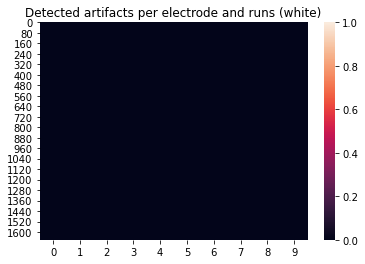

In [20]:
reject_channels_full_of_artifacts = True

if reject_channels_full_of_artifacts:
    rej_ch = p3k.detec_rej_channel(raw=raw,
                                   threshold_eeg=artifact_threshold,
                                   reject_ratio=ratio_tolerated_artifacts,
                                   show_plot=True)
    if rej_ch is not None:
        p3k.flag_channels_as_bad(rej_ch)

## Artifact Subspace Reconstruction fitting and reconstruction

In [21]:
if apply_ASR:
    #!pip install meegkit pymanopt
    asr_model = p3k.train_asr(raw)

    raw = p3k.apply_asr(raw=raw,
                        asr_model=asr_model,
                        display_plot=display_plots.asr)

### Convert text annotations (i.e. unprocessed events) into events

**Small but major hack to realign events due to conversion**



In [22]:
# Parse annotations with the follwing mapping
# non-target=0, target=1, new_trial=10 and stimulus_1=101
new_annotations, target_map = p3k.parse_annotations(raw.annotations,
                                                    speller_info=speller_info,
                                                    acquisition_software=acquisition_software,
                                                    stimulus_code_begin=STIMULUS_CODE_BEGIN)
raw.set_annotations(new_annotations)

Row labels: ['101' '102' '103' '104' '105' '106' '107']
Col labels: ['108' '109' '110' '111' '112' '113' '114']


<RawGDF | loic_gammabox.gdf, 10 x 42528 (166.1 s), ~3.3 MB, data loaded>

In [23]:
target_map

{'0': 0,
 '1': 1,
 '10': 10,
 '101': 101,
 '102': 102,
 '103': 103,
 '104': 104,
 '105': 105,
 '106': 106,
 '107': 107,
 '108': 108,
 '109': 109,
 '110': 110,
 '111': 111,
 '112': 112,
 '113': 113,
 '114': 114}

Then we can convert annotations into events

In [24]:
all_events, event_id = mne.events_from_annotations(raw, event_id=target_map)
print("Found {} events".format(len(all_events[:])))
event_id

Used Annotations descriptions: ['0', '1', '10', '101', '102', '103', '104', '105', '106', '107', '108', '109', '110', '111', '112', '113', '114']
Found 1405 events


{'0': 0,
 '1': 1,
 '10': 10,
 '101': 101,
 '102': 102,
 '103': 103,
 '104': 104,
 '105': 105,
 '106': 106,
 '107': 107,
 '108': 108,
 '109': 109,
 '110': 110,
 '111': 111,
 '112': 112,
 '113': 113,
 '114': 114}

In [25]:
raw.info["ch_names"]

['Fz', 'FC1', 'FC2', 'C1', 'Cz', 'C2', 'P3', 'Pz', 'P4', 'Oz']

### Pick the channels

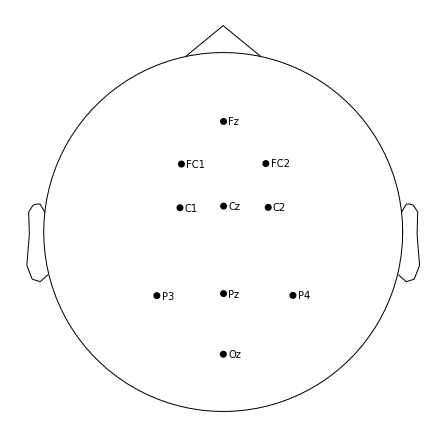

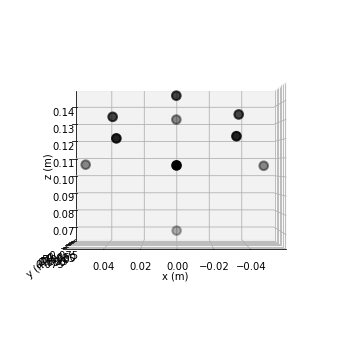

In [26]:
# pick all channels
picks = mne.pick_channels(raw.info["ch_names"], include=[])
picks
raw.plot_sensors(show_names=True)
fig = raw.plot_sensors('3d')

## Epoching from events

### Prepare metadata to annotate events
When making target and non-target epochs, we need to conserve stimulus related information.
(trial number, stimulus number, column and row information)

Metadata is a pandas dataframe with as many rows as there are events, and describes events signal on its columns

In [27]:
df_meta = p3k.metadata_from_events(events=all_events,
                                   speller_info=speller_info,
                                   stimulus_code_begin=STIMULUS_CODE_BEGIN)


df_meta

,Trial_nb,stim,is_row,is_col,is_target
0,1,111,0,1,0
1,1,106,1,0,0
2,1,109,0,1,0
3,1,104,1,0,0
4,1,112,0,1,0
...,...,...,...,...,...
695,5,105,1,0,0
696,5,114,0,1,0
697,5,103,1,0,0
698,5,108,0,1,0


### Make epochs
Note that the epochs are created based on the events.
We only select targets and non targets, those should match exactly with stimuli annotations made in metadata

Adding metadata with 5 columns
Replacing existing metadata with 5 columns
700 matching events found
Applying baseline correction (mode: mean)
0 projection items activated
Loading data for 700 events and 206 original time points ...
0 bad epochs dropped


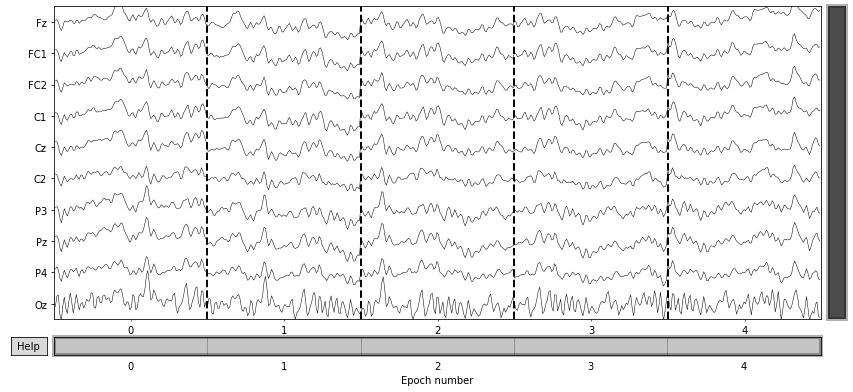

In [28]:
# since we use metadata we can pick only target and non-target events
events = mne.pick_events(all_events, [0, 1])



# epoching function
epochs = mne.Epochs(raw, events, baseline=time_baseline,
                    event_id=EVENT_IDS,
                    tmin=time_epoch[0], tmax=time_epoch[1],
                    event_repeated='drop', picks=['eeg', 'csd'],
                    preload=True,
                    metadata=df_meta)

# if there is any delay,
#epochs.shift_time(-isi, relative=True)
if display_plots.epochs:
    fig = epochs[0:5].plot(title='displaying 5 first epochs')

### Making a cross correlation plot between the electrodes to see how channels relate

In [29]:
if display_plots.cross_correlation:

    m = np.corrcoef(raw._data)
    fig = plt.figure()
    hm = sns.heatmap(m, linewidths=0, cmap="YlGnBu").set(title='Cross correlation')


### Epoch rejection
Please filter out channels before epochs. A problematic channel can discard the whole recording

In [30]:
# This function can render classification impossible
# @todo notify row/col P300 speller counterpart when rejecting an epoch
if reject_artifactual_epochs:
    reject_criteria = dict(eeg=artifact_threshold)  # 100 µV  #eog=200e-6)
    _ = epochs.drop_bad(reject=reject_criteria)
    if display_plots.reject_epochs:
        epochs.plot_drop_log()

## Apply current source density

In [31]:
if apply_CSD:
    print("Applying CSD")
    epochs_csd = mne.preprocessing.compute_current_source_density(epochs)
    epochs = epochs_csd
    if display_plots.csd:
        fig = epochs_csd[0:5].plot(title='Current_source_density on 5 first epochs')


### Average the epochs of each class

target and non target signal plots

joint plot (of the two former graphs). Plase not that Y scales differ between plots 

No projector specified for this dataset. Please consider the method self.add_proj.


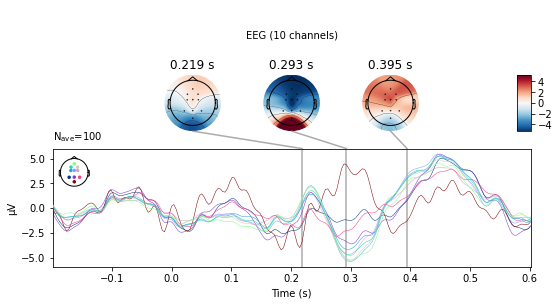

No projector specified for this dataset. Please consider the method self.add_proj.


<Figure size 432x288 with 0 Axes>

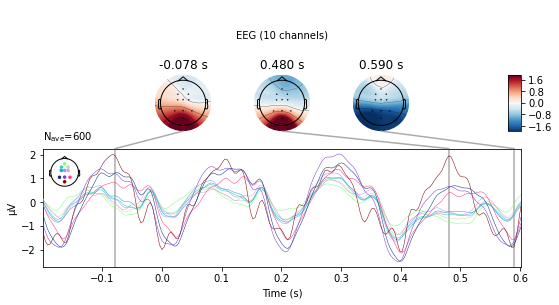

<Figure size 432x288 with 0 Axes>

In [32]:
if display_plots.butterfly_topomap:
    p3k.plot_butterfly_topomap(epochs=epochs)

### Target vs NonTarget Erps per channel

plotting channel 1
plotting channel 2
plotting channel 3
plotting channel 4
plotting channel 5
plotting channel 6
plotting channel 7
plotting channel 8
plotting channel 9
plotting channel 10
plotting averaged channels
More than 6 channels, truncating title ...
combining channels using "mean"
combining channels using "mean"


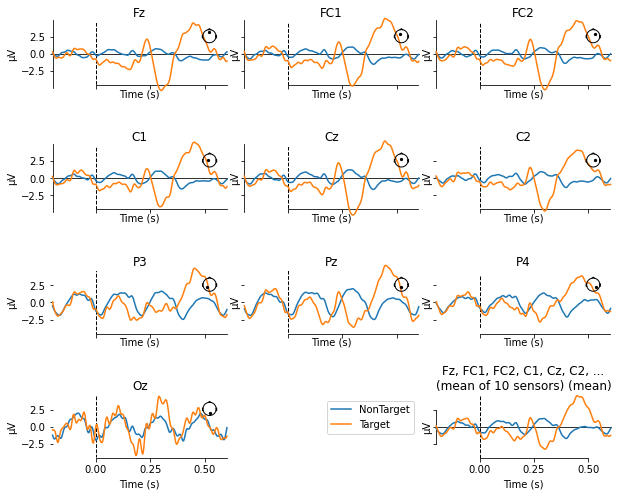

In [33]:
if display_plots.channel_average:
    fig = p3k.plot_channel_average(epochs=epochs)

if export_figures:
    out_name = os.path.join(fig_folder, output_name + '_ERPs')
    fig.savefig(out_name, dpi=300, facecolor='w', edgecolor='w', bbox_inches='tight')

### Display single epochs

In [34]:
if display_plots.erp_heatmap:
    p3k.plot_erp_heatmaps(epochs=epochs)

### Same plot but channel wise

In [35]:
if display_plots.erp_heatmap_channelwise:
    p3k.plot_erp_heatmaps_channelwise(epochs=epochs, csd_applied=apply_CSD)

# Classical LDA training

resample the signal, we don't need that much

In [36]:
new_fs = resample_LDA  #
epochs_resampled = epochs.copy().resample(new_fs)
print('resampling to {}Hz'.format(new_fs))

resampling to 32Hz


fold score: 0.964, AUC=0.896
fold score: 0.957, AUC=0.85
fold score: 0.9, AUC=0.733
fold score: 0.879, AUC=0.783
fold score: 0.929, AUC=0.833
Average score 5-Fold = 0.93, AUC=0.82
Score training-validation 0.94, AUC=0.89
Score is only valid if classes are balanced target_ratio=0.14
 please refer to AUC instead


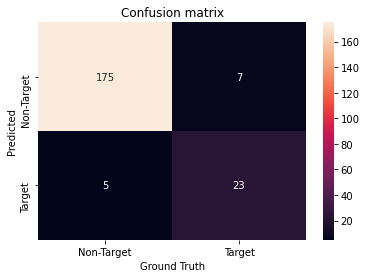

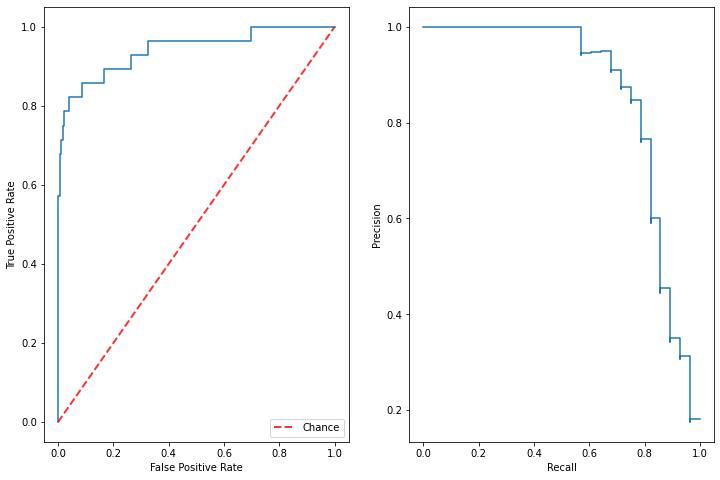

In [37]:
fig_conf, fig_roc = p3k.run_single_epoch_LDA_analysis(X_data=epochs_resampled._data,
                                      y_true_labels=epochs_resampled.events[:, 2],
                                      nb_k_fold=nb_cross_fold)

if export_figures:
    out_name = os.path.join(fig_folder, output_name + '_confidence_matrix')
    fig_conf.savefig(out_name, dpi=300, facecolor='w', edgecolor='w', bbox_inches='tight')
    out_name = os.path.join(fig_folder, output_name + '_ROC')
    fig_roc.savefig(out_name, dpi=300, facecolor='w', edgecolor='w', bbox_inches='tight')

## Process the ROC curve and precision recall


## Signed R-Square plot
function adapted from wyrm

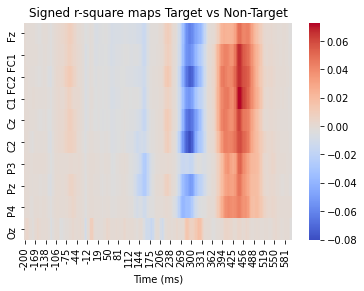

In [38]:
rsq = None
if display_plots.signed_r_square:
    rsq, fig_rsq = p3k.signed_r_square(epochs=epochs,
                                  time_epoch=time_epoch,
                                  display_rsq_plot=display_plots.signed_r_square)
    if export_figures:
        out_name = os.path.join(fig_folder, output_name + '_heatmap')
        fig_rsq.savefig(out_name, dpi=300, facecolor='w', edgecolor='w', bbox_inches='tight')

### make a pandas database to properly display electrodes and samples



### Quickly Display a channel with max rsq

combining channels using "mean"
combining channels using "mean"


C:\BCI\dev\p300_analysis_from_openvibe\p3k\p3k.py:447: RuntimeWarning: Only 1 channel in "picks"; cannot combine by method "mean".
  fig_handle = mne.viz.plot_compare_evokeds(evokeds, picks=picks, combine='mean')


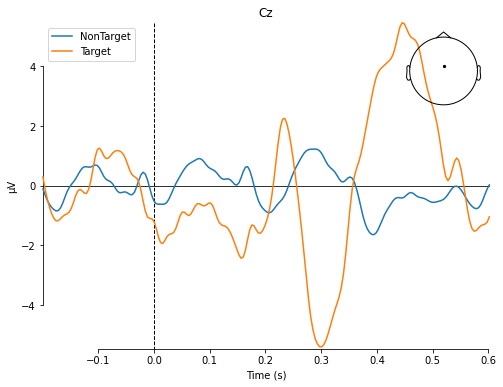

In [39]:
if rsq is not None and display_plots.signed_r_square and display_plots.best_channel_erp:
    if display_channel_erp is None:
        ch_max, _ = np.where(rsq == np.max(rsq))
        display_channel_erp = epochs.info['ch_names'][int(ch_max)]

    #picks = [f'eeg{n}' for n in range(10, 15)]
    #evokeds = dict(NonTarget=list(epochs['NonTarget'].iter_evoked()),
    #               Target=list(epochs['Target'].iter_evoked()))
    axs = p3k.plot_average_erp(epochs=epochs, picks=display_channel_erp)

    if export_figures:
        out_name = os.path.join(fig_folder, output_name + '_best_channel')
        axs[0].savefig(out_name, dpi=300, facecolor='w', edgecolor='w', bbox_inches='tight')



# Extract offline analysis, using shrinkage LDA

### Extract correct target pair

#### Custom functions to extract performance in a cumulative way 
By cumulative, it uses either the first sequence, then first and second, and so on until all sequences are considered.\
This allows for choosing an optimal number of sequences

#### Resampling for faster LDA

In [40]:
new_fs = resample_LDA  #
epochs_resampled = epochs.copy().resample(new_fs)
print('resampling to {}Hz'.format(new_fs))

resampling to 32Hz


#### Checking whether the number of folds matches the total number of trials

In [41]:
# Check whether we can proceed to k split

#### LDA for P300 speller target prediction 

In [42]:
cum_score_table = p3oddball.run_p300_LDA_analysis(epochs=epochs_resampled,
                                              nb_k_fold= nb_cross_fold,
                                              speller_info=speller_info)
import numpy as np

fold 0 partial score: 0.964, AUC=0.896
fold 1 partial score: 0.957, AUC=0.85
- LDA detected no target in an iteration of length 7. Marking best candidate as target every 7 prediction
- LDA detected no target in an iteration of length 14. Marking best candidate as target every 7 prediction
fold 2 partial score: 0.9, AUC=0.733
fold 3 partial score: 0.879, AUC=0.783
- LDA detected no target in an iteration of length 7. Marking best candidate as target every 7 prediction
fold 4 partial score: 0.929, AUC=0.833


#### Prediction results
**fold**: k-fold\
**fold_trial**: index of trial contained in the fold\
**n_seq**: number of sequences selecting epoch for predictions\
**score**: LDA score (target vs non-target detection). Classes are unbalanced so the score is misleading\
**AUC**: LDA Area Under the Curve. Estimation of the performance of the classifier\
**row/col_pred/true**: row and columns target and predicted\
**correct**: the predicted row **AND** column is correctly predicted

In [43]:
cum_score_table[:]

,fold,fold_trial,n_seq,score,AUC,row_true,row_pred,col_true,col_pred,correct
0,1,1,1,0.928571,0.958333,1,1,8,8,1
1,1,1,2,0.964286,0.979167,1,1,8,8,1
2,1,1,3,0.97619,0.986111,1,1,8,8,1
3,1,1,4,0.982143,0.989583,1,1,8,8,1
4,1,1,5,0.971429,0.941667,1,1,8,8,1
5,1,1,6,0.964286,0.909722,1,1,8,8,1
6,1,1,7,0.969388,0.922619,1,1,8,8,1
7,1,1,8,0.973214,0.932292,1,1,8,8,1
8,1,1,9,0.968254,0.912037,1,1,8,8,1
9,1,1,10,0.964286,0.895833,1,1,8,8,1


In [46]:
import importlib
from p3k import openvibe

importlib.reload(p3k)
importlib.reload(p3k.openvibe)
importlib.reload(p3oddball)
#all_events.shape

<module 'p3k.classification.p3oddball' from 'C:\\BCI\\dev\\p300_analysis_from_openvibe\\p3k\\classification\\p3oddball.py'>

#### Make a human readable plot of these results

Number of ERP targets=100, non-targets=600


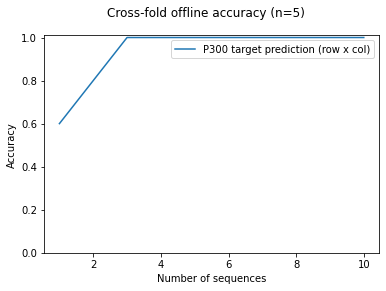

In [47]:
display_plots = DisplayPlots()
fig_score = p3oddball.plot_cum_score_table(table=cum_score_table, nb_cross_fold=nb_cross_fold)

if display_plots.offline_accuracy:
    out_name = os.path.join(fig_folder, output_name + '_accuracy')
    fig_score.savefig(out_name, dpi=300, facecolor='w', edgecolor='w', bbox_inches='tight')



print("Number of ERP targets={}, non-targets={}".format(epochs['Target']._data.shape[0],
                                                        epochs['NonTarget']._data.shape[0]))

